This is notebook file is the Solution for Question 2 of the Exercise 2 from the [exercise series 2](https://github.com/righetti/optlearningcontrol/tree/master/Spring2020/series2) for the course Optimal and Learning Control (ME-GY 7973), as solved by Tarun Thathvik Paladugu. All the content from the file [exercise 2 - cart pole.ipynb](https://github.com/righetti/optlearningcontrol/blob/master/Spring2020/series2/exercise%202%20-%20cart%20pole.ipynb) was used as provided by professor [Ludovic Righetti](https://engineering.nyu.edu/faculty/ludovic-righetti).

# Stabilizing the Cart-Pole system

In this exercise, we will use LQR to stabilize a cart-pole system and then adapt the LQR controller to get the robot to move along a specified path.

<img src="cart_pole.png" alt="drawing" width="400"/>

The difficulty of the cart-pole system is that we can only move the cart back and forth (using $u$) to move both the cart and the pendulum. Therefore, it is not trivial to find a good controller to get the pendulum to stay balanced on top of the cart while moving the cart around. We will see how we can use our optimal control approach to do such things.

In [1]:
# setup matplotlib for nice display in Jupyter
%matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

# note in order to use the animation package to display movies you will need to install ffmpeg
# on Mac with homebrew: brew install ffmpeg
# on ubuntu: apt-get install ffmpeg
# on windows: https://ffmpeg.org/download.html#build-windows
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

## The cart-pole model

The dynamics of the cart-pole can be written as
\begin{align} 
\dot{x} &= v\\
\dot{\theta} &= \omega\\
\dot{v} &= \frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta} \\
 \dot{\omega} &= \frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\end{align}
 
There are four states: the position $x$ and linear velocity $v$ of the cart, the angle of the pendulum $\theta$ and its angular velocity $\omega$. There is one control input $u$ which is the force applied on the cart. We will write $z = \begin{bmatrix} x & \theta & v & \omega \end{bmatrix}^T$ the state vector.

We know that the point where the pendulum is vertical is an unstable fixed point of the system. We would like to stabilize the fixed point $\bar{z} = \begin{bmatrix} \bar{x} & \bar{\theta} & \bar{v} & \bar{\omega} \end{bmatrix}^T = \begin{bmatrix} 0 & \pi & 0 & 0 \end{bmatrix}^T$.

Like most robotic systems, it is not linear. It is also underactuated, i.e. we have only one control input to control two degrees of freedom.

We will first linearize the system around $\bar{z}$ (with $\bar{u}=0$) and then compute a LQR control law to stabilize it. The control law will be approximately optimal for the nonlinear system but should be a good enough approximation when sufficiently close to the fixed point.

## Linearizing the dynamics
We linearize $\dot{z} = f(z,u) \simeq f(\bar{z},\bar{u}) + \frac{\partial f}{\partial z}_{|z=\bar{z}, u=\bar{u}} (z - \bar{z}) + \frac{\partial f}{\partial u}_{|z=\bar{z}, u=\bar{u}}(u - \bar{u})$.

We have $f(\bar{z},\bar{u}) = 0$. 

Next, we compute the partial derivatives of the dynamics with respect to all state and control variables.

For the first two equations, this is straightforward:
\begin{equation}\frac{\partial}{\partial x} v = 0,\ \frac{\partial}{\partial \theta} v = 0, \ \frac{\partial}{\partial v} v = 1,\ \frac{\partial}{\partial \omega} v = 0\end{equation}
\begin{equation}\frac{\partial}{\partial x} \omega = 0,\ \frac{\partial}{\partial \theta} \omega = 0, \ \frac{\partial}{\partial v} \omega = 0,\ \frac{\partial}{\partial \omega} \omega = 1\end{equation}

For the third equation:
$$\frac{\partial}{\partial x} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta} \right) = 0$$
$$\frac{\partial}{\partial \theta} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{(m_p\cos\theta(l \omega^2 + g \cos\theta) - m_pg\sin^2\theta)(m_c  + m_p \sin^2 \theta) - (u + m_p \sin\theta (l \omega^2 + g \cos\theta)) (2m_p \sin\theta\cos\theta) }{(m_c  + m_p \sin^2 \theta)^2}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{m_p g}{m_c}$$
Now for the linear velocity
$$\frac{\partial}{\partial v} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = 0$$
and for the angular velocity
$$\frac{\partial}{\partial \omega} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{2m_p \sin\theta l \omega}{m_c  + m_p \sin^2 \theta}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives 0

Finally we have
$$\frac{\partial}{\partial x} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = 0$$
$$\frac{\partial}{\partial \theta} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{(u\sin\theta - m_p l \omega^2 (\cos^2\theta - \sin^2 \theta) - (m_c + m_p)g\cos\theta) (l(m_c  + m_p \sin^2 \theta)) - (-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta)(2l m_p \sin\theta\cos\theta)}{(l(m_c  + m_p \sin^2 \theta))^2}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{(m_p + m_c) g}{lm_c}$$
For the linear velocity
$$\frac{\partial}{\partial v} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = 0$$
and finally
$$\frac{\partial}{\partial \omega} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{- 2m_p l \omega\cos\theta \sin\theta}{l(m_c  + m_p \sin^2 \theta)}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives 0.

We now compute the partial derivatives with respect to the control command. We have
$$\frac{\partial}{\partial u} v = 0$$
$$\frac{\partial}{\partial u} \omega = 0$$
$$\frac{\partial}{\partial u} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{1}{m_c  + m_p \sin^2 \theta}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{1}{m_c}$$
and the last one
$$\frac{\partial}{\partial u} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{-\cos\theta}{l(m_c  + m_p \sin^2 \theta)}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{1}{lm_c}$$

We can gather all these terms and get the linearized dynamics
$$\dot{z} = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} (z - \bar{z}) + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} (u-\bar{u})$$

Finally, we change coordinates to center around the linearized point, we set $\tilde{z} = z - \bar{z}$ and $\tilde{u} = u-\bar{u}$ and get the following dynamics
$$\dot{\tilde{z}} = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} \tilde{z} + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} \tilde{u}$$


In [2]:
class CartPole:
    """
    This class describes a cart pole model and provides some helper functions
    """
    
    def __init__(self):
        """
        constructor of the class, takes as input desired discretization number
        for x (angle), v (angular velocity) and u (control) and the maximum control
        """
        #store discretization information
        self.road_length = 3.
        
        #gravity constant
        self.g=9.81

        #integration step
        self.dt = 0.01
        
        #we define lengths and masses
        self.l = 1.0
        self.mc = 5.0
        self.mp = 1.0
            
    def next_state(self,z,u):
        """
        Inputs:
        z: state of the cart pole syste as a numpy array (x,theta,v,omega)
        u: control as a scalar number
        
        Output:
        the new state of the pendulum as a numpy array
        """
        x = z[0]
        th = z[1]
        v = z[2]
        om = z[3]
        x_next = (x + self.dt * v)
        th_next = (th + self.dt * om)
        v_next = v + self.dt*((u + self.mp*np.sin(th)*(self.l*om**2 + self.g * np.cos(th)))/(self.mc+self.mp*np.sin(th)**2))
        w_next = om + self.dt*((-u*np.cos(th)-self.mp*self.l*(om**2)*np.cos(th)*np.sin(th)-(self.mc+self.mp)*self.g*np.sin(th))/(self.mc+self.mp*np.sin(th)**2))
        z = np.array([x_next,th_next,v_next,w_next])
        return z
    
    def simulate(self, z0, controller, horizon_length):
        """
        This function simulates the pendulum of horizon_length steps from initial state x0
        
        Inputs:
        z0: the initial conditions of the pendulum as a numpy array (x,theta,v,omega)
        controller: a function that takes a state z as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        
        Output:
        z[4xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        z=np.empty([4, horizon_length+1])
        z[:,0] = z0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            u[:,i] = controller(z[:,i],i)
            z[:,i+1] = self.next_state(z[:,i], u[:,i])
        return z, u        

In [3]:
def animate_cart_pole(x, dt):
    """
    This function makes an animation showing the behavior of the cart-pole
    takes as input the result of a simulation (with dt=0.01s)
    """
    
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    
    #what we need to plot
    plotx = x[:,::steps]
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-4.25,4.25], ylim=[-1.,1.4])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    cart_length = 0.5
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - cart_length
        x_front = plotx[0,i] + cart_length
        y_up = cart_height
        y_down = 0.
        x_pend = plotx[0,i] + np.sin(plotx[1,i])
        y_pend = cart_height - np.cos(plotx[1,i])
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([plotx[0,i], x_pend], [cart_height, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

# Question 2:
We would like to use the linearized equation to compute an optimal controller that makes the cart follow a 0.5Hz sine trajectory of amplitude 1 (i.e. $x$ displacement from -1 to 1 meter) while keeping the pendulum balanced.

1. Write a cost function that will help enforce this behavior (be precise with the variables you use).
2. Compute the finite horizon controller that creates this behavior for $N=1000$ (i.e. 10 seconds).
3. Test the behavior of the robot using $z_0 = [0.5, \pi + 0.3, 0., 0.]^T$. Plot the time evolution of the control input and the states of the system. How well can you track the desired motion?
4. What is the cost value predicted by the control design? How does it compare to the real cost value when applied to the nonlinear system? Explain.

#### 1) 
Since the position of the cart is to follow a given trajectory, in a finite horizon, we use implement the following cost function. 

$$ \min_{\mathbf{u}_n} \sum_{n=0}^{N} \left[\mathbf({z}_{n}-\bar{z_{n}})^T \mathbf{Q}_n ({z}_{n}-\bar{z_{n}}) + {u}_n^T \mathbf{R}_n {u}_n\right]$$

while $\bar{z_{n}}$ is the desired value of $z_{n}$ from the trajectory.

This then equals, 

$$ \min_{\mathbf{u}_n} \sum_{n=0}^{N} \left[{z}_{n}^T \mathbf{Q}_n {z}_{n} +\bar{z_{n}}^T \mathbf{Q}_n \bar{z_{n}} - 2 \bar{z_{n}}\mathbf{Q}_n z_{n} + {u}_n^T \mathbf{R}_n {u}_n\right]$$

Since $\bar{z_{n}}^T \mathbf{Q}_n \bar{z_{n}}$ does not depend on the state or the control input, we ignore the term, making the cost fucntion: 

$$ \min_{\mathbf{u}_n} \sum_{n=0}^{N} \left[{z}_{n}^T \mathbf{Q}_n {z}_{n} - 2 \bar{z_{n}}\mathbf{Q}_n z_{n} + {u}_n^T \mathbf{R}_n {u}_n\right]$$

Comparing this to the standard Quadratic cost function: 

$$ \min_{\mathbf{u}_n} \sum_{n=0}^{N} \left[{z}_{n}^T \mathbf{Q}_n {z}_{n} + {u}_n^T \mathbf{R}_n {u}_n +2 x_{n}^T\mathbf S_{n}u_{n} + 2 \mathbf q_{n}^Tx_{n} + 2 \mathbf r_{n}^Tu_{n}\right]$$

it is noticable that $S_{n} = 0, r_{n} = 0$, and $q_{n} = - Q \bar{z_n}$

#### 2)
To get the control gain for this system to follow the given trajectory is found using the following Ricatti equations

\begin{equation}
K_n = - (B^{T} P_{n+1} B + R)^{-1} B^{T} P_{n+1} A 
\end{equation}
\begin{equation}
k_n = - (B^{T} P_{n+1} B + R)^{-1} B^{T} p_{n+1}
\end{equation}
\begin{equation}
    P_{n} = Q + A^{T} P_{n+1} A + A^{T} P_{n+1} B K_{n} 
\end{equation}
\begin{equation}
    p_{n} = q_{n} + A^{T} P_{n+1} A + A^{T} p_{n+1} k_{n} 
\end{equation}

The $K$ is the feedback gain, and the $k$ is the feedforward gain.

These equations are solved in the fuction defined below &darr;

In [4]:
def solve_ricatti_equations(A,B,Q,R,q,horizon_length):
    
    P = []
    p = []
    K = []
    k = []
    d = []
    
    # Terminal conditions
    P.append(Q)  
    p.append(q[horizon_length]) 
    d.append(0)
    
    for i in reversed(range(horizon_length)):
        Knew = - 1.0 * np.linalg.inv(B.transpose().dot(P[0]).dot(B) + R).dot(B.transpose()).dot(P[0]).dot(A)
        Pnew = Q + A.transpose().dot(P[0]).dot(A) + A.transpose().dot(P[0]).dot(B).dot(Knew)
        knew = - 1.0 * np.linalg.inv(B.transpose().dot(P[0]).dot(B) + R).dot(B.transpose()).dot(p[0])
        pnew = q[i] + A.transpose().dot(p[0]).dot(A) + A.transpose().dot(P[0]).dot(B).dot(knew)
        dnew = 0.5*(B.transpose().dot(p[0])).transpose().dot(knew)+d[0]
        
        K.insert(0, Knew)
        k.insert(0, knew)
        P.insert(0, Pnew)
        p.insert(0, pnew)
        d.insert(0, dnew)
    
    # since we went backward we return reverted lists
    return P, K, p, k, d

The control input uses a feedback and a feedforward, since it is trying not only to keep the system in the current desired state, but also drive the system to the next desired state, therefore following the desired trajectory: 

\begin{equation}
    u_{n} = K (z_{n}-\bar{z_{n}})-k_n
\end{equation}

A function performing the same is defined below &darr;

In [5]:
def LQ_traj(z,i):
    # z_bar SHOULD BE DEFINED AS A GLOBAL VARIABLE for this function to work.
    return K[i].dot(z-z_bar[i])+k[i]

The desired Trajectory $\bar{z}$ is defined in the given horizon for $N = 1000$.

$$\bar{z_n} = sin(2\pi n f \Delta t)$$
$$f=0.5\text{Hz}$$

Where $f$ is the frequency of the desired sine trajectory. 

$\bar{z}$ and $q$ are both defined in the block below &darr;

In [6]:
#1
# we call the created cart 
cart = CartPole()

# defining the given horizon length
horizon_length = 1000

# definig the dynamics of the system
A = np.array([[1, 0, cart.dt, 0],[0, 1, 0, cart.dt],[0, cart.dt*cart.mp*cart.g/cart.mc, 1, 0], [0, cart.dt*(cart.mp+cart.mc)*cart.g/(cart.l*cart.mc), 0, 1]])
B = np.array([[0],[0],[cart.dt/cart.mc],[cart.dt/(cart.l*cart.mc)]])

# definig the cost terms Q & R
Q = np.array([[10000, 0, 0, 0],[0, 10000, 0, 0],[0, 0, 10, 0],[0, 0, 0, 10]])*1000
R = np.eye(1)*100

# defining the desired trajectory and q
z_bar = []
q = []

# to make the system work desirably, a different slightly different q was taken.
C = np.array([[1000, 0, 0, 0],[0, 1000, 0, 0],[0, 0, 10, 0],[0, 0, 0, 10]])*100


for i in range(horizon_length+1):
    znew = np.array([np.sin(np.pi*i*cart.dt), np.pi, 0, 0])
    qnew = -1.0*C.dot(znew)
    
    z_bar.append(znew)
    q.append(qnew)

# Call in a function to solve the Ricatti Equations, so to get P, K, p, k, and d 
P, K, p, k, d = solve_ricatti_equations(A,B,Q,R,q,horizon_length)

#### 3)
The cart is  simulated with the following initial state:

$$z_{0} = \begin{bmatrix}
            0.5\\ \pi+0.3 \\ 0 \\ 0
           \end{bmatrix} $$

In [7]:
z0 = np.array([0.5,np.pi+0.3,0.,0.])

z,u = cart.simulate(z0, LQ_traj, horizon_length)

<IPython.core.display.Javascript object>


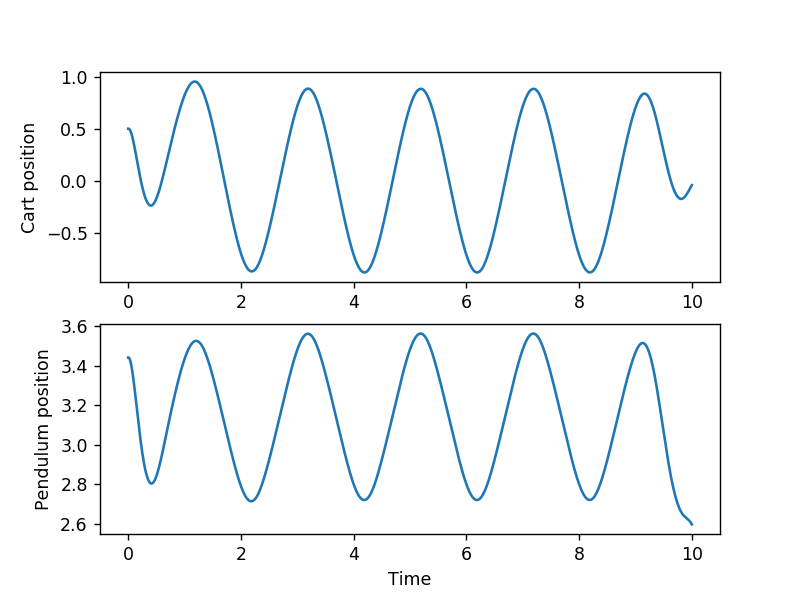

Text(0.5, 0, 'Time')

In [8]:
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('Pendulum position')
plt.xlabel('Time')

In [9]:
animate_cart_pole(z, cart.dt)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAB65m1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA/CZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S0FxzClEFKxd1+TNS++zCta62/NP06dt9j0J6Dkf2rHaFv+dr20t1Bp3zX58
DBmkFpamrwUtoW26plf3qfo7kHaQyI08hEByMoaqItBilNRZ9xftAaNrfFzgbRx0zytlSZ7wyT/A
hWDCoOtQa0dEz95yhN3uVkH/sJoWqLvH6jo9pLsuTBPgi8kL8+yRBKPqVQ/YUDgwspb8Gnl6iUwZ
SurlWB0QXIgiBsb9xLD0CubzvixG8obluC6puxpOWyCYkAba0WR1yHfSXQQ/y0f6jOWghUvdIBsG
igBzV4ev+v7HoGNhrn4HAmg+LgXYw01UJYCHvx71Tte9SRfibeCOi6JkrNAX3JBi6i0VcfBn5uxY
0cQ7f6meMVl82jxIiNyfUAGiXxs8qxyQLlJpZ0sHtM/GvWXE/omglH/sdo/uEXTJId6hPu7WmKdv
n7ORQzhyrsN16xtn5uNtfP+DN3Osku4qW8AL/+F9UAFOrDX77aTosKsZp1docCwqM/rxyz21Gilx
wxqBBx/NVqVW66OAMoZSh0yMNV1iwRhiCOJDKPb0TxOPY2wuLvxX0CWH4z/LTXvrSXMWWfL6fZ4N
irJ4QeS9fDDuMu8yQIbbRLX60CB6+iYSijgIo1ayAFAKBVvL1f3jECe2gzyp1Cv8o9LJ/lvjy0NP
s2Xpte/oRJpP2jzKIpqNr2uEmmlD+rlGYafpJS81K4U3Lxc5F7UgLsZhtaZ9A9vaAkH718Y+UHWP
H20Hv3yKTfQafN1aZw9xc/FyF0h7KK5eUWTwQi6Z0ULgLtW03qPjIuOiUsP1tZp6RhNS41+XyEd7
qLGBDilJOlkruJ8e4F/QI1x0znL5/lhRbFtbdf73f29NVRz2UYfsqofAL/oenpsooS4ehf+KnTj1
V8SOR42MIjxsee5w8gB4rT56q68lbR8NAAADAMu/s5Ero1R9n/UktIt8jTuhbGf/j+nMk1xXigSG
XZ9h4WsBOPr9Ej33T5OqqlqCzvegvLJNyC06FtmA/Xa0BTHpqq1kxAA+36FR1VqwxUuinuoFU3tH
JwBjfndkGSSHoy7ogvqloUCyUQULDb7sjW5m8tXh8wVX02UOGfjP25OZSWDR00PL2poWVddpXH1f
pdskDvFilI89K67YU07Lt3IgIJ6VfC7AxmTfs48vd5EcAF+SPuoLRHjStCZa2+F8LaKOaOBey+jC
au/kpoM/VwndlsiLBMYH8NoA9qyx/dQy9T8qhGcTRlz991AFwkQSsESoAADDIZj5RYlyThAUfcbS
+K/R7ict7Vd277L/OIu5QVSQ54ayY8wpzKpE4yetGtwiHwKBtfYI2IVT7IzHf+MQNt/AQzPge0dA
pMnY2QACu5ZJNYhWetIoduFrsvDrVSbM2HGcGmKfZkV9IRrulDXzpX2Py+SsEV4SoxVcQ9TSGAeH
AJPXTVKsT9XRk+9R0n+euv7Jf4zoq5FPFGkNYQbn13j37z/VeHiSuRHQzuxNW+FycWyHXur7Vvj3
njqtPp7PtjndaQkPuOnHbUfU9mV8wrDNsQZF4yL0+2siqcOrZ0DO9NFa+6nhYMujwz93csf+l5tu
DIos+Dfe8AsumfIbP7N7JiHD/4Pfu1fB0b89SC8Yz47Pd8FVvabRQlSIoL7EDqQ/82KAvxEtbfT1
kilWq++RmCIV/jqhRs7HNLexAdRrn8cuJub4kE0luhq5a2/SWAh8s4kadFT5X0aPWtsExuL7kkFA
fVi9C2fjgMIZs01l4mDXxLyi/KxE87dyIEKfR1Bn/lpg22Bj2dL+2Sr2yAg81k26twzkg53HD6Fz
jIJgRPy0ea6/dzyb5ZZQE5a4sUubJ4m7CnM/nQGpMMRDmvMhQzWney5mdbtzBosiJ4hOdAaoAARg
H/SUPYsFYw1WMQDT+NRQAwePJAiD743qRu2AT2pwvkymvrZ1VGToMc+WB1v/ELVDQKkriPGaJywf
MGpm/roXK08xht4AIhKaTRef2D8Icc+cfIYFNtsePzglrw11AAm5sgVljjsUpar/sH4XoFjbUqJ2
oA+DkvqUmIYexh5vTYrIhETXhY5YAVViQTrPEt6/jPeCbHiQQH2CdmwvfJEIUMM97z5HmtXneR6r
ciQpWNUAKiZ4U7LHqxkBKU2KIeldqynvmqjYTrlT4sTjL6KwZJDEEL4CrgdO7+cnBbOqwXh0A1kU
98pw00V+fKv76myqLz+Jwb8sE1q0qsUINs69aVBNhEeltHNtYUQ9avp1HdGDUg9XSx1KGtKnVVmz
M7HbTUpVySjsIyx0+GgzSmK0UR4Y3Xdg6JG3vY46gP735KK16d1AzjmjZYmB8fTDf11P4eVpgg9L
fW8CKqjqoVJZCfai01cBffvTg2GTBkwqtAIK8Ag5DIr6zrJ8yLVfT4ueHhTMcU6xgDkCfeBIwUB8
+KHLR5IPuOLA4KnjVgu62sPk/dtRPz9+qeMn/5dXBZ6WHSXMmaXHtEzauaHEK08tImY3d4+gmp+x
lFjd1aih5mG1YycqiRdrHkndhzjrlq2kjrOTohGDsQC1CEcwnIXTJWjE3Co9AqCuA7JsIdBIEnPp
eFCZBkFjczTQPsjrVN+P08tlugWQNLcr02Je2bD5LqICE9ynUaXqgJMPVqywP26x77sPkBmLq2ze
NwNrsPTQVBvQDxvLUu53lv+7+YlzoORaTkmEQ3bSnZv8I7U5FMDo9r899O4qQRvEsdrTNtJPh6wE
SrZQmsRPpIyJajQ3ExchzYWOOrWuVNhprWT8N7hEErJf4iji3PK5wCNcncCdHy1FinG53cGC7W5R
ww3751bausnIGstQeiGN2

#### 4)

Cost value predicted by the control design is: 

$$J_{0}(z_{0})=z_{0}^T\mathbf P_{0} z_{0} + \mathbf p_{n}^T z_{0} + d_{0}$$

This cost is calculated below &darr;

In [10]:
print("The predicted cost value is", z[:,0].transpose().dot(P[0]).dot(z[:,0])+p[0].transpose().dot(z[:,0])+d[0])

The predicted cost value is 22798468923.74825


The real cost value when applied to the nonlinear system is calculated using the following formula:

$$ \min_{\mathbf{u}_n} \sum_{n=0}^{N-1} \left[\frac{1}{2}{z}_{n}^T \mathbf{Q} {z}_{n} - \mathbf{q_{n}} z_{n} + \frac{1}{2}{u}_n^T \mathbf{R} {u}_n\right] + \frac{1}{2}{z}_{N}^T \mathbf{Q} {z}_{N} - \mathbf{q_{N}} z_{N}$$

The considered cost of the system is calculated below &darr;

In [11]:
for i in range(horizon_length):
    cost = 0.5*(z[:,i].transpose().dot(Q).dot(z[:,i])+u[:,i].transpose().dot(R).dot(u[:,i])) + q[i].transpose().dot(z[:,i])

cost = cost + 0.5*(z[:,horizon_length].transpose().dot(Q).dot(z[:,horizon_length])) + q[horizon_length].transpose().dot(z[:,horizon_length])

print("The cost is", cost)

The cost is 65941268.8232643


The difference between the predicted cost from the control design and the actual cost from the non-linear system is considerably large. This is due to the fact that the system is linearized in the control design, while the actual system is still non-linear. Therefore this linear cost-to-go cannot correctly predict the actual cost of the non-linear system.